In [12]:
# Data processing
# ====================================
import pandas as pd
import numpy as np
import math

# Plots
# ====================================
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Data analysis
# ====================================
from scipy import stats

# Utils
# ====================================
from itertools import product
from collections import Counter

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, recall_score, precision_score
from sklearn import set_config

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer

In [15]:
train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_data.csv')

In [16]:
passthrough_mineralDensity_preprocessor = ColumnTransformer([
        # (name, transformer, columns)
        ("temperatureFirstHalfPlanetRotation", make_pipeline(SimpleImputer(missing_values=-999.0, strategy='median'), FunctionTransformer(lambda f: (f - 32) / 1.8, feature_names_out="one-to-one"), StandardScaler()), ['temperatureFirstHalfPlanetRotation']),
        ("temperatureSecondHalfPlanetRotation", StandardScaler(), ['temperatureSecondHalfPlanetRotation']),
        ("waterStreamDistanceX", make_pipeline(FunctionTransformer(lambda f: f * 0.3048, feature_names_out="one-to-one"), StandardScaler()), ['waterStreamDistanceX']),
        ("waterStreamDistanceY", StandardScaler(), ['waterStreamDistanceY']),
        ("planetSection", OneHotEncoder(handle_unknown = "ignore"), ['planetSection']),
        ("cover", OrdinalEncoder(handle_unknown='error'), ['cover']),
        ("climaticZone", OrdinalEncoder(handle_unknown="error"), ['climaticZone']),
        ("geoZone", OneHotEncoder(handle_unknown = "error"), ['geoZone']),
        ("rockSize", OneHotEncoder(handle_unknown = "error"), ['rockSize']),
        ("magmaConcentrationDistance", OneHotEncoder(handle_unknown = "ignore"), ['magmaConcentrationDistance']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0) TODO: use Ordinal Encoder?
        ("mineralDensity", 'passthrough', ['mineralDensity']),
        # ("detectionDepth", make_pipeline(FunctionTransformer(lambda f: f * 1000, feature_names_out="one-to-one"), StandardScaler()), ['detectionDepth']),
        ("detectionDepth", StandardScaler(), ['detectionDepth']), # pass through the column unchanged TODO: convert km to m?
        ("longitude", make_pipeline(FunctionTransformer(lambda f: f % 360, feature_names_out="one-to-one"), StandardScaler()), ['longitude']),
        # ("longitude", StandardScaler(), ['longitude']), # pass through the column unchanged TODO: values > 360? do x - 360
    ],
    verbose_feature_names_out=False, remainder='passthrough'
)

passthrough_temperatureFirstHalfPlanetRotation_preprocessor = ColumnTransformer([
        # (name, transformer, columns)
        ("temperatureFirstHalfPlanetRotation", 'passthrough', ['temperatureFirstHalfPlanetRotation']),
        ("temperatureSecondHalfPlanetRotation", StandardScaler(), ['temperatureSecondHalfPlanetRotation']),
        ("waterStreamDistanceX", make_pipeline(FunctionTransformer(lambda f: f * 0.3048, feature_names_out="one-to-one"), StandardScaler()), ['waterStreamDistanceX']),
        ("waterStreamDistanceY", StandardScaler(), ['waterStreamDistanceY']),
        ("planetSection", OneHotEncoder(handle_unknown = "ignore"), ['planetSection']),
        ("cover", OrdinalEncoder(handle_unknown='error'), ['cover']),
        ("climaticZone", OrdinalEncoder(handle_unknown="error"), ['climaticZone']),
        ("geoZone", OneHotEncoder(handle_unknown = "error"), ['geoZone']),
        ("rockSize", OneHotEncoder(handle_unknown = "error"), ['rockSize']),
        ("magmaConcentrationDistance", OneHotEncoder(handle_unknown = "ignore"), ['magmaConcentrationDistance']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0) TODO: use Ordinal Encoder?
        ("mineralDensity", make_pipeline(SimpleImputer(missing_values=-999.0, strategy='median'), StandardScaler()), ['mineralDensity']),
        # ("detectionDepth", make_pipeline(FunctionTransformer(lambda f: f * 1000, feature_names_out="one-to-one"), StandardScaler()), ['detectionDepth']),
        ("detectionDepth", StandardScaler(), ['detectionDepth']), # pass through the column unchanged TODO: convert km to m?
        ("longitude", make_pipeline(FunctionTransformer(lambda f: f % 360, feature_names_out="one-to-one"), StandardScaler()), ['longitude']),
        # ("longitude", StandardScaler(), ['longitude']), # pass through the column unchanged TODO: values > 360? do x - 360
    ],
    verbose_feature_names_out=False, remainder='passthrough'
)

In [17]:
train_copy = train.copy()
train_copy = train_copy.drop(['mineralType', 'id'], axis=1)

# mineralDensity

In [18]:
preprocessed_train = passthrough_mineralDensity_preprocessor.fit_transform(train_copy)
X = pd.DataFrame(preprocessed_train, columns=passthrough_mineralDensity_preprocessor.get_feature_names_out())
X

,temperatureFirstHalfPlanetRotation,temperatureSecondHalfPlanetRotation,waterStreamDistanceX,waterStreamDistanceY,planetSection_Hyrule,planetSection_Mordor,planetSection_Tatoooine,cover,climaticZone,geoZone_1,...,rockSize_2,rockSize_3,magmaConcentrationDistance_CLOSE,magmaConcentrationDistance_FAR,magmaConcentrationDistance_MEDIUM,magmaConcentrationDistance_VERY_CLOSE,magmaConcentrationDistance_VERY_FAR,mineralDensity,detectionDepth,longitude
0,0.058797,0.062969,0.177788,-0.561392,0.0,0.0,1.0,4.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4617.64,0.036297,-0.797784
1,-0.163287,1.300463,-0.923458,-0.637252,0.0,0.0,1.0,0.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9859.22,-0.008990,-1.542678
2,1.248530,0.705213,-0.924247,-0.804866,0.0,1.0,0.0,3.0,6.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-999.00,1.170855,-1.156188
3,0.693322,-0.469623,-0.876572,-0.641185,1.0,0.0,0.0,4.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-999.00,-1.188836,-0.142806
4,1.200941,0.156956,-1.074219,-0.835997,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3991.21,-0.988620,-0.406998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12616,-1.178526,-1.111866,-0.872966,-0.673135,0.0,1.0,0.0,3.0,6.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10576.29,1.421126,-0.440533
12617,1.074036,1.472772,0.231856,-0.178976,0.0,0.0,1.0,4.0,2.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,6457.13,0.339005,1.907539
12618,1.026447,0.767871,0.626084,-0.506668,0.0,1.0,0.0,3.0,5.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-999.00,1.085048,-1.237301
12619,0.344333,1.300463,4.127995,2.629992,0.0,0.0,1.0,3.0,5.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10078.16,1.256662,2.204533


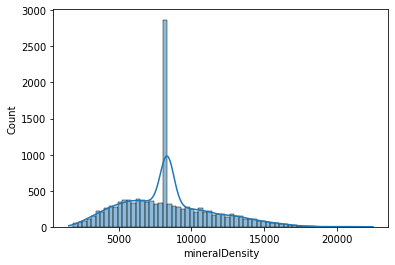

In [19]:
knn_imputed = KNNImputer(missing_values=-999.0, n_neighbors=10, weights="distance").fit_transform(X['mineralDensity'].values.reshape(len(X['mineralDensity']), 1))
knn_mineralDensity = pd.DataFrame(knn_imputed, columns=['mineralDensity'])
sns.histplot(data=knn_mineralDensity, x='mineralDensity', kde=True)
plt.show()

In [20]:
knn_mineralDensity

,mineralDensity
0,4617.640000
1,9859.220000
2,8332.314814
3,8332.314814
4,3991.210000
...,...
12616,10576.290000
12617,6457.130000
12618,8332.314814
12619,10078.160000


8332.314814 es el valor que imputa

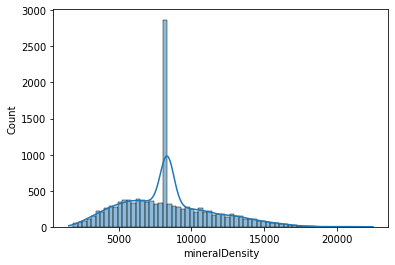

In [21]:
iterativeImputer_imputed = IterativeImputer(missing_values=-999.0).fit_transform(X['mineralDensity'].values.reshape(len(X['mineralDensity']), 1))
iterativeImputer_mineralDensity = pd.DataFrame(iterativeImputer_imputed, columns=['mineralDensity'])
sns.histplot(data=iterativeImputer_mineralDensity, x='mineralDensity', kde=True)
plt.show()

In [22]:
iterativeImputer_mineralDensity

,mineralDensity
0,4617.640000
1,9859.220000
2,8332.314814
3,8332.314814
4,3991.210000
...,...
12616,10576.290000
12617,6457.130000
12618,8332.314814
12619,10078.160000


8332.314814 es el valor que imputa

# temperatureFirstHalfPlanetRotation

In [23]:
preprocessed_train = passthrough_temperatureFirstHalfPlanetRotation_preprocessor.fit_transform(train_copy)
X = pd.DataFrame(preprocessed_train, columns=passthrough_temperatureFirstHalfPlanetRotation_preprocessor.get_feature_names_out())
X

,temperatureFirstHalfPlanetRotation,temperatureSecondHalfPlanetRotation,waterStreamDistanceX,waterStreamDistanceY,planetSection_Hyrule,planetSection_Mordor,planetSection_Tatoooine,cover,climaticZone,geoZone_1,...,rockSize_2,rockSize_3,magmaConcentrationDistance_CLOSE,magmaConcentrationDistance_FAR,magmaConcentrationDistance_MEDIUM,magmaConcentrationDistance_VERY_CLOSE,magmaConcentrationDistance_VERY_FAR,mineralDensity,detectionDepth,longitude
0,-999.0,0.062969,0.177788,-0.561392,0.0,0.0,1.0,4.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.172853,0.036297,-0.797784
1,103.0,1.300463,-0.923458,-0.637252,0.0,0.0,1.0,0.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.526080,-0.008990,-1.542678
2,111.9,0.705213,-0.924247,-0.804866,0.0,1.0,0.0,3.0,6.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.121725,1.170855,-1.156188
3,108.4,-0.469623,-0.876572,-0.641185,1.0,0.0,0.0,4.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.121725,-1.188836,-0.142806
4,111.6,0.156956,-1.074219,-0.835997,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.375895,-0.988620,-0.406998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12616,96.6,-1.111866,-0.872966,-0.673135,0.0,1.0,0.0,3.0,6.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.758501,1.421126,-0.440533
12617,110.8,1.472772,0.231856,-0.178976,0.0,0.0,1.0,4.0,2.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.576626,0.339005,1.907539
12618,110.5,0.767871,0.626084,-0.506668,0.0,1.0,0.0,3.0,5.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.121725,1.085048,-1.237301
12619,106.2,1.300463,4.127995,2.629992,0.0,0.0,1.0,3.0,5.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.597044,1.256662,2.204533


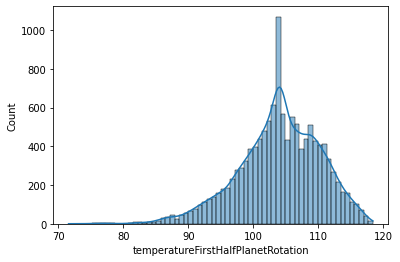

In [27]:
knn_imputed = KNNImputer(missing_values=-999.0, n_neighbors=10, weights="distance").fit_transform(X['temperatureFirstHalfPlanetRotation'].values.reshape(len(X['temperatureFirstHalfPlanetRotation']), 1))
knn_mineralDensity = pd.DataFrame(knn_imputed, columns=['temperatureFirstHalfPlanetRotation'])
sns.histplot(data=knn_mineralDensity, x='temperatureFirstHalfPlanetRotation', kde=True)
plt.show()

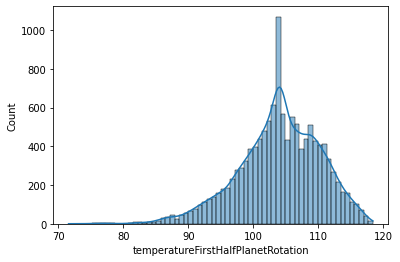

In [25]:
iterativeImputer_imputed = IterativeImputer(missing_values=-999.0).fit_transform(X['temperatureFirstHalfPlanetRotation'].values.reshape(len(X['temperatureFirstHalfPlanetRotation']), 1))
iterativeImputer_mineralDensity = pd.DataFrame(iterativeImputer_imputed, columns=['temperatureFirstHalfPlanetRotation'])
sns.histplot(data=iterativeImputer_mineralDensity, x='temperatureFirstHalfPlanetRotation', kde=True)
plt.show()

# Test KNN imputa adecuadamente o debe ponerse después de un primer preprocessor

In [38]:
imputed_preprocessor = ColumnTransformer([
        # (name, transformer, columns)
        ("temperatureFirstHalfPlanetRotation", make_pipeline(SimpleImputer(missing_values=-999.0, strategy='median'), FunctionTransformer(lambda f: (f - 32) / 1.8, feature_names_out="one-to-one"), StandardScaler()), ['temperatureFirstHalfPlanetRotation']),
        ("temperatureSecondHalfPlanetRotation", StandardScaler(), ['temperatureSecondHalfPlanetRotation']),
        ("waterStreamDistanceX", make_pipeline(FunctionTransformer(lambda f: f * 0.3048, feature_names_out="one-to-one"), StandardScaler()), ['waterStreamDistanceX']),
        ("waterStreamDistanceY", StandardScaler(), ['waterStreamDistanceY']),
        ("planetSection", OneHotEncoder(handle_unknown = "ignore"), ['planetSection']),
        ("cover", OrdinalEncoder(handle_unknown='error'), ['cover']),
        ("climaticZone", OrdinalEncoder(handle_unknown="error"), ['climaticZone']),
        ("geoZone", OneHotEncoder(handle_unknown = "error"), ['geoZone']),
        ("rockSize", OneHotEncoder(handle_unknown = "error"), ['rockSize']),
        ("magmaConcentrationDistance", OneHotEncoder(handle_unknown = "ignore"), ['magmaConcentrationDistance']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0) TODO: use Ordinal Encoder?
        ("mineralDensity", make_pipeline(KNNImputer(missing_values=-999.0, n_neighbors=10, weights="distance"), StandardScaler()), ['mineralDensity']),
        # ("detectionDepth", make_pipeline(FunctionTransformer(lambda f: f * 1000, feature_names_out="one-to-one"), StandardScaler()), ['detectionDepth']),
        ("detectionDepth", StandardScaler(), ['detectionDepth']), # pass through the column unchanged TODO: convert km to m?
        ("longitude", make_pipeline(FunctionTransformer(lambda f: f % 360, feature_names_out="one-to-one"), StandardScaler()), ['longitude']),
        # ("longitude", StandardScaler(), ['longitude']), # pass through the column unchanged TODO: values > 360? do x - 360
    ],
    verbose_feature_names_out=False, remainder='passthrough'
)

In [39]:
X = train.copy().drop(['mineralType', 'id'], axis=1)

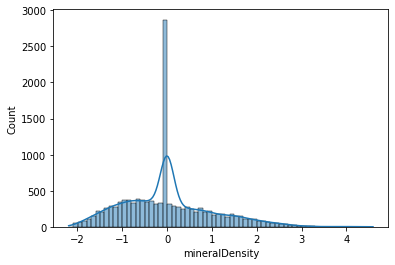

In [40]:
knn_imputed = imputed_preprocessor.fit_transform(X)
knn_mineralDensity = pd.DataFrame(knn_imputed, columns=imputed_preprocessor.get_feature_names_out())
sns.histplot(data=knn_mineralDensity, x='mineralDensity', kde=True)
plt.show()

El imputer da el mismo resultado ya se aplique el resto del preprocesamiento antes o después.

Un enfoque podría ser buscar la configuración de los imputers más efectiva en cuanto al accuracy.